In [1]:
from typing import Optional, List, Type, Tuple, Dict
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In this gentle introduction, we are going to construct a Gaussian probability path defined by $p_t(\cdot) = N(\cdot | \alpha_t z, \beta_t \cdot I)$, where $\alpha_t = t$, $\beta_t = \sqrt{1 - t}$, and $t$ is a time index in the interval $[0, 1]$.

### Step 0: construct target data and initial distribution

/Users/bachdo01/Documents/research/generative_models/diffusion_model/.venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


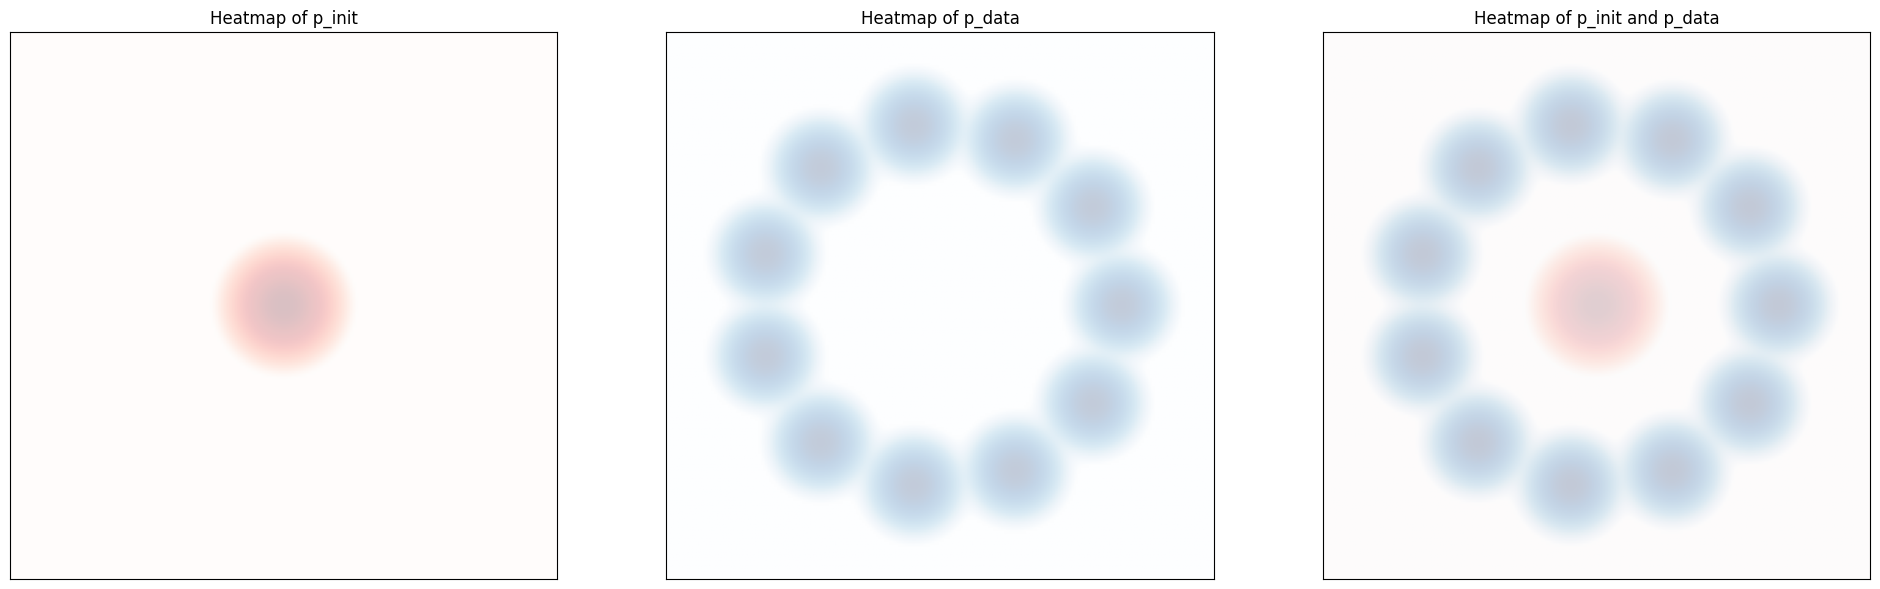

In [2]:
from gaussian import Gaussian, GaussianMixture
from ultility import plot_comparison_heatmap

# Constants for the duration of our use of Gaussian conditional probability paths, to avoid polluting the namespace...
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}

p_init = Gaussian.standard(dim=2, std = 1.0).to(device)
p_data = GaussianMixture.symmetric_2D(nmodes=11, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)
plot_comparison_heatmap(p_init, p_data, PARAMS['scale'])

### Step 1: Build Gaussian Conditional Probability Path

In [3]:
from gaussian import Sampleable

class StandardNormal(nn.Module, Sampleable):
    """
    Sampleable wrapper around torch.randn
    """
    def __init__(self, shape: List[int], std: float = 1.0):
        """
        shape: shape of sampled data
        """
        super().__init__()
        self.shape = shape
        self.std = std
        self.dummy = nn.Buffer(torch.zeros(1)) # Will automatically be moved when self.to(...) is called...

    def sample(self, num_samples) -> torch.Tensor:
        return self.std * torch.randn(num_samples, *self.shape).to(self.dummy.device)

In [6]:
class LinearAlpha:
    """
    Implements alpha_t = t
    """
    def __init__(self):
        # Check alpha_t(0) = 0
        assert torch.allclose(
            self(torch.zeros(1,1,1,1)), torch.zeros(1,1,1,1)
        )
        # Check alpha_1 = 1
        assert torch.allclose(
            self(torch.ones(1,1,1,1)), torch.ones(1,1,1,1)
        )

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - alpha_t (num_samples, 1)
        """
        return t

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """
        return torch.ones_like(t)
        

class SquareRootBeta:
    """
    Implements beta_t = rt(1-t)
    """
    def __init__(self):
        # Check beta_0 = 1
        assert torch.allclose(
            self(torch.zeros(1,1,1,1)), torch.ones(1,1,1,1)
        )
        # Check beta_1 = 0
        assert torch.allclose(
            self(torch.ones(1,1,1,1)), torch.zeros(1,1,1,1)
        )

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - t: time (num_samples, 1)
        Returns:
            - beta_t (num_samples, 1)
        """
        return torch.sqrt(1 - t)

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates d/dt alpha_t.
        Args:
            - t: time (num_samples, 1)
        Returns:
            - d/dt alpha_t (num_samples, 1)
        """
        return - 0.5 / (torch.sqrt(1 - t) + 1e-4)

In [7]:
class GaussianConditionalProbabilityPath(nn.Module):
    def __init__(self, p_data: Sampleable, alpha: LinearAlpha, beta: SquareRootBeta):
        super().__init__()
        p_init = StandardNormal(shape = [p_data.dim], std = 1.0)
        self.p_init = p_init
        self.p_data = p_data
        
        self.alpha = alpha
        self.beta = beta

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, c, h, w)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z, _ = self.sample_conditioning_variable(num_samples) # (num_samples, c, h, w)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, c, h, w)
        return x

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z and label y
        Args:
            - num_samples: the number of samples
        Returns:
            - z: (num_samples, c, h, w)
            - y: (num_samples, label_dim)
        """
        return self.p_data.sample(num_samples)

    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, c, h, w)
        """
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)

    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t) # (num_samples, 1, 1, 1)
        beta_t = self.beta(t) # (num_samples, 1, 1, 1)
        dt_alpha_t = self.alpha.dt(t) # (num_samples, 1, 1, 1)
        dt_beta_t = self.beta.dt(t) # (num_samples, 1, 1, 1)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x

    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, c, h, w)
            - z: conditioning variable (num_samples, c, h, w)
            - t: time (num_samples, 1, 1, 1)
        Returns:
            - conditional_score: conditional score (num_samples, c, h, w)
        """
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

NameError: name 'Alpha' is not defined

In [7]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = p_data,
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

#### Step 1.5: Visualize the conditional path from $X_0$ to a data point in $p_{\text{data}}$

In [ ]:
from ultility import plot_conditional_path

plot_conditional_path(path , p_init, p_data, PARAMS['scale'])

### Step 2: Learn vector the field $u(x, t)$ with MLP neural net

In [9]:
class MLPVectorField(torch.nn.Module):
    """
    MLP-parameterization of the learned vector field u_t^theta(x)
    """
    def get_mlp(self, dims: List[int], activation: Type[torch.nn.Module] = torch.nn.SiLU):
        mlp = []
        for idx in range(len(dims) - 1):
            mlp.append(torch.nn.Linear(dims[idx], dims[idx + 1]))
            if idx < len(dims) - 2:
                mlp.append(activation())
        return torch.nn.Sequential(*mlp)

    def __init__(self, dim: int, hiddens: List[int]):
        super().__init__()
        self.dim = dim
        self.net = self.get_mlp([dim + 1] + hiddens + [dim])

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        Args:
        - x: (bs, dim)
        Returns:
        - u_t^theta(x): (bs, dim)
        """
        xt = torch.cat([x,t], dim=-1)
        return self.net(xt)

In [10]:
from trainer import Trainer

class ConditionalFlowMatchingTrainer(Trainer):
    def __init__(self, path: GaussianConditionalProbabilityPath, model: MLPVectorField, **kwargs):
        super().__init__(model, **kwargs)
        self.path = path

    def get_train_loss(self, batch_size: int) -> torch.Tensor:
      z = self.path.p_data.sample(batch_size)
      t = torch.rand(batch_size, 1)
      x = self.path.sample_conditional_path(z, t)
      u_theta = self.model(x, t)
      u_ref = self.path.conditional_vector_field(x, z, t)

      return torch.mean((u_theta - u_ref)**2)

In [ ]:
# Construct learnable vector field
flow_model = MLPVectorField(dim=2, hiddens=[1024,16])

# Construct trainer
trainer = ConditionalFlowMatchingTrainer(path, flow_model)
losses = trainer.train(num_epochs=5000, device=device, lr=1e-3, batch_size=1000)

In [12]:
torch.save(flow_model.state_dict(), "trained/gmm_mlp_fm.pt")

### Step 3 : Generate samples from learned model

In [ ]:
from ode import LearnedVectorFieldODE, EulerSimulator

num_samples = 1000
num_timesteps = 300
num_marginals = 3

ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)
x0 = path.p_init.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

In [ ]:
from importlib import reload
from ultility import plot_generated_sample

plot_generated_sample(xts, ts, p_init, p_data, scale = PARAMS['scale'], num_samples=num_samples, num_timesteps=num_timesteps, num_marginals=num_marginals)